In [1]:
!pip install seaborn

You are using pip version 7.0.3, however version 8.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [15]:
# -*- coding: utf-8 -*-
%matplotlib inline
import bz2
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import cPickle as pickle
import sys
import re
import seaborn as sns

from lang_map import code_lang_map
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from collections import Counter


####Calculate the percentages from a pandas dataframe of letter counts and add the percentages as new columns to the given dataframe

In [3]:
def percentages(df):
    df2 = df.join(df.div(df['letters_count'], axis='index'), rsuffix='_perc')
    percs = [col for col in df2.columns if col.endswith('_perc')]
    return df2[percs]

####Count the number of times each character occurs in each language and grab the top 2000 from each of them

In [4]:
def get_top_letters():
    files = os.listdir('articles')
    top_letters = []    
    for f in files:        
        c = Counter()
        for article in parse('articles/'+f):
            c['articles_count'] += 1
            for letter in article['content']:
                c[letter] += 1
                c['letters_count'] += 1
        d = dict(c.most_common(2000))
        d['lang'] = os.path.splitext(f)[0]
        top_letters.append(d)
    return top_letters

####Parse data from the scrubbed wikipedia articles using regex and return a dictionary

In [5]:
def parse(filename):
    data = ""
    # regex pattern for scrubbing extracted wikipedia article 
    article_rgx = re.compile(
    r'<doc id="(?P<id>\d+)" url="(?P<url>[^"]+)" title="(?P<title>[^"]+)">\n(?P<content>.+)\n<\/doc>', re.S | re.U)
    with io.open(filename, 'r', encoding='utf8') as f:
        for line in f:
            #line = line.decode('utf-8')
            data += line
            if line.count('</doc>'):
                m = article_rgx.search(data)
                if m:
                    yield m.groupdict()
                data = ""

####Load the articles dictionary back from pickle

In [6]:
def load_data():
    f = open('letters2.pkl', 'rb')
    data = pickle.load(f)
    f.close()
    return data

####Save the articles dictionary into pickle

In [35]:
def dump_data():   
    top_letters = get_top_letters()  
    with open('letters2.pkl', 'wb') as handle:
        pickle.dump(top_letters, handle, protocol=2) 

In [7]:
data = load_data() 

In [8]:
df = DataFrame(data)
df.fillna(0, inplace=True)
df = df.set_index('lang')

In [9]:
df

,,,!,"""",#,$,%,&,',(,...,ｍ,ｎ,ｐ,ｚ,～,｢,｣,､,￼,�
lang,,,,,,,,,,,,,,,,,,,,,
ar,83595,3852786,551,41465,94,138,3897,46,552,24992,...,0,0,0,0,0,0,0,0,0,0
bg,63516,2695979,430,27985,25,214,4013,134,701,26644,...,0,0,0,0,0,0,0,0,1,0
ca,94031,5139533,858,91075,148,101,4348,185,227845,42403,...,0,0,0,0,0,0,0,0,1,0
cs,73349,2981587,421,44276,42,57,4313,188,1423,39133,...,0,0,0,0,0,0,0,0,0,0
da,62393,2577203,308,55627,98,321,3096,729,6793,18269,...,0,0,0,0,0,0,0,0,0,0
de,158733,7488125,1118,144548,253,209,8685,1284,1826,69541,...,0,0,0,0,0,0,0,0,0,0
en,156617,9991721,2380,361454,1794,10915,9058,3350,127764,59698,...,0,0,0,0,0,0,0,0,0,1
eo,43128,1363501,1613,34458,45,42,1909,114,1630,19180,...,0,0,0,0,0,0,0,0,0,0
es,135800,8008102,789,139208,310,935,7391,731,5547,55752,...,0,0,0,0,0,0,0,0,2,0


In [10]:
df3 = percentages(df)
df3.values[np.isnan(df3.values)] = np.median(df3.values[~np.isnan(df3.values)])
df3

,_perc,_perc,!_perc,"""_perc",#_perc,$_perc,%_perc,&_perc,'_perc,(_perc,...,ｍ_perc,ｎ_perc,ｐ_perc,ｚ_perc,～_perc,｢_perc,｣_perc,､_perc,￼_perc,�_perc
lang,,,,,,,,,,,,,,,,,,,,,
ar,0.003595,0.165686,0.000024,0.001783,4.042390e-06,5.934573e-06,0.000168,0.000002,0.000024,0.001075,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
bg,0.003506,0.148829,0.000024,0.001545,1.380104e-06,1.181369e-05,0.000222,0.000007,0.000039,0.001471,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,5.520417e-08,0.000000e+00
ca,0.002943,0.160856,0.000027,0.002850,4.632084e-06,3.161084e-06,0.000136,0.000006,0.007131,0.001327,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,3.129786e-08,0.000000e+00
cs,0.003517,0.142946,0.000020,0.002123,2.013610e-06,2.732756e-06,0.000207,0.000009,0.000068,0.001876,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
da,0.003642,0.150450,0.000018,0.003247,5.720957e-06,1.873905e-05,0.000181,0.000043,0.000397,0.001066,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
de,0.002860,0.134936,0.000020,0.002605,4.559059e-06,3.766179e-06,0.000157,0.000023,0.000033,0.001253,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
en,0.002512,0.160279,0.000038,0.005798,2.877783e-05,1.750892e-04,0.000145,0.000054,0.002049,0.000958,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.604116e-08
eo,0.004810,0.152059,0.000180,0.003843,5.018455e-06,4.683891e-06,0.000213,0.000013,0.000182,0.002139,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
es,0.002724,0.160636,0.000016,0.002792,6.218362e-06,1.875538e-05,0.000148,0.000015,0.000111,0.001118,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,4.011847e-08,0.000000e+00


In [11]:
num_clusters = 4
palette = sns.color_palette('colorblind', num_clusters)

### Run KMeans clustering algorithm on letter percentages
#### KMeans automatically groups the data together based on similarity

In [12]:
est = KMeans(num_clusters, max_iter=30000)
est.fit(df3.values)
y_kmeans = est.predict(df3.values)

###Run Principal Component Analysis to reduce the number of columns from 10000 to 2

In [13]:
pca = PCA(n_components=2)
pca.fit(df3.values)
X_trans = pca.transform(df3.values)

###Plot the results

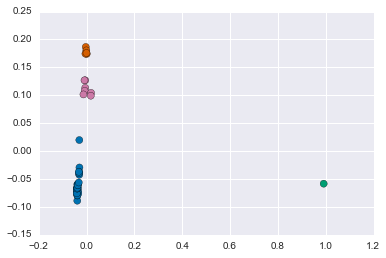

In [16]:
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=[palette[y] for y in y_kmeans], s=50)

###Find the languages that are most similar

In [17]:
cluster_dfs = {}
cluster_langs = {}
cluster_distances = {}
langs = list(code_lang_map.keys())

In [19]:
for cluster_num in range(4):
    indexes = [i for i in range(y_kmeans.shape[0]) if y_kmeans[i] == cluster_num]
    print(indexes)
    cluster_langs[cluster_num] = [langs[i] for i in indexes]
    cluster_dfs[cluster_num] = df3.loc[cluster_langs[cluster_num], :]

    # Calculate pairwise distances and display
    print('Cluster #{0}'.format(cluster_num))

    # Calculate the Euclidian distance between each pair of points
    # the smaller the distance the more similar the data points are
    cluster_distances[cluster_num] = pairwise_distances(cluster_dfs[cluster_num].values)
    n, m = cluster_distances[cluster_num].shape
    distances = set([])
    for i in range(n):
        for j in range(m):
            if i == j:
                continue
            distances.add((cluster_distances[cluster_num][i, j], tuple(sorted([i, j]))))
    for a in sorted(distances)[:20]:
        print(a[0])
        print(a[1][0])
        print(a[1][1])
        print(cluster_langs[cluster_num])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 37]
Cluster #0
0.0134930582372
13
24
['bg', 'zh', 'uk', 'hr', 'tr', 'ca', 'de', 'vo', 'fr', 'eu', 'ar', 'et', 'hu', 'id', 'es', 'pt', 'fa', 'kk', 'sr', 'no', 'ko', 'ja', 'sk', 'en', 'ms', 'it', 'ro']
0.0134930582373
13
24
['bg', 'zh', 'uk', 'hr', 'tr', 'ca', 'de', 'vo', 'fr', 'eu', 'ar', 'et', 'hu', 'id', 'es', 'pt', 'fa', 'kk', 'sr', 'no', 'ko', 'ja', 'sk', 'en', 'ms', 'it', 'ro']
0.0369898458834
5
14
['bg', 'zh', 'uk', 'hr', 'tr', 'ca', 'de', 'vo', 'fr', 'eu', 'ar', 'et', 'hu', 'id', 'es', 'pt', 'fa', 'kk', 'sr', 'no', 'ko', 'ja', 'sk', 'en', 'ms', 'it', 'ro']
0.0382281250592
14
15
['bg', 'zh', 'uk', 'hr', 'tr', 'ca', 'de', 'vo', 'fr', 'eu', 'ar', 'et', 'hu', 'id', 'es', 'pt', 'fa', 'kk', 'sr', 'no', 'ko', 'ja', 'sk', 'en', 'ms', 'it', 'ro']
0.0448013395959
5
8
['bg', 'zh', 'uk', 'hr', 'tr', 'ca', 'de', 'vo', 'fr', 'eu', 'ar', 'et', 'hu', 'id', 'es', 'pt', 'fa', 'kk', 'sr', 'no', 'ko', 'j